# <center style="font-family: consolas; font-size: 32px; font-weight: bold;"> ❤️HuBMAP - Hacking the Human Vasculature - Exploratory Data Analysis</center>
<p><center style="color:#949494; font-family: consolas; font-size: 20px;">Segment instances of microvascular structures from healthy human kidney tissue slides.</center></p>

***

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">(ಠಿ⁠_⁠ಠ) Overview</center>

<p style="font-family: consolas; font-size: 16px;">⚪ <code>Goal</code>: The goal of the competition is to develop a model that can segment instances of microvascular structures, such as capillaries, arterioles, and venules, in 2D PAS-stained histology images from healthy human kidney tissue slides.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ <code>Importance</code>: Automating the segmentation of microvasculature structures will help improve researchers' understanding of how blood vessels are arranged in human tissues. This knowledge is crucial for studying the interaction, organization, and specialization of cells in the body.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ <code>Context</code>: The competition is aligned with the efforts of the Human BioMolecular Atlas Program (HuBMAP), which aims to map healthy cells in the human body. The Vasculature Common Coordinate Framework (VCCF) is a navigation system that uses blood vasculature to map cellular locations. However, there are gaps in knowledge about microvasculature, and automating segmentation can help fill those gaps and contribute to the development of the VCCF and a Human Reference Atlas (HRA).</p>

<p style="font-family: consolas; font-size: 16px;">⚪ <code>Research Focus</code>: HuBMAP researchers are studying the connections between cells throughout the body using advanced molecular and cellular biology technologies. By segmenting microvasculature arrangements, machine learning insights can augment their understanding of how these small vessels are distributed, leading to a better understanding of the relationships between cells and their impact on human health.</p>



#### <a id="top"></a>
# <div style="box-shadow: rgb(60, 121, 245) 0px 0px 0px 3px inset, rgb(255, 255, 255) 10px -10px 0px -3px, rgb(31, 193, 27) 10px -10px, rgb(255, 255, 255) 20px -20px 0px -3px, rgb(255, 217, 19) 20px -20px, rgb(255, 255, 255) 30px -30px 0px -3px, rgb(255, 156, 85) 30px -30px, rgb(255, 255, 255) 40px -40px 0px -3px, rgb(255, 85, 85) 40px -40px; padding:20px; margin-right: 40px; font-size:30px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(60, 121, 245);"><b>Table of contents</b></div>

<div style="background-color: rgba(60, 121, 245, 0.03); padding:30px; font-size:15px; font-family: consolas;">
<ul>
    <li><a href="#0" target="_self" rel=" noreferrer nofollow">0. Import all dependencies</a></li>
    <li><a href="#1" target="_self" rel=" noreferrer nofollow">1. Data overview</a>
        <ul>
            <li><a href="#1.1" target="_self" rel=" noreferrer nofollow">1.1 Files and Field Descriptions</a></li>
        </ul>
        <ul>
            <li><a href="#1.2" target="_self" rel=" noreferrer nofollow">1.2 Whole Slide Images metadata</a></li>
        </ul>
        <ul>
            <li><a href="#1.3" target="_self" rel=" noreferrer nofollow">1.3 Each image metadata</a></li>
        </ul>
        <ul>
            <li><a href="#1.4" target="_self" rel=" noreferrer nofollow">1.4 Tiles visualisation</a></li>
        </ul>
    </li>
</ul>

</div>


<a id="0"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 0. Import all dependencies </b></div>

In [2]:
import os
import json
from PIL import Image
from collections import Counter

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import tifffile as tiff
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'PIL'

In [3]:
!pip install PIL

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [2]:
class CFG:
    img_path_template: str = "/kaggle/input/hubmap-hacking-the-human-vasculature/train/{}.tif"

In [3]:
def get_cartesian_coords(coords, img_height):
    coords_array = np.array(coords).squeeze()
    xs = coords_array[:, 0]
    ys = -coords_array[:, 1] + img_height
    
    return xs, ys

In [4]:
def plot_annotated_image(image_dict, scale_factor: int = 1.0) -> None:
    array = tiff.imread(CFG.img_path_template.format(image_dict["id"]))
    img_example = Image.fromarray(array)
    annotations = image_dict["annotations"]
    
    # create figure
    fig = go.Figure()

    # constants
    img_width = img_example.size[0]
    img_height = img_example.size[1]
    

    # add invisible scatter trace
    fig.add_trace(
        go.Scatter(
            x=[0, img_width],
            y=[0, img_height],
            mode="markers",
            marker_opacity=0
        )
    )

    # configure axes
    fig.update_xaxes(
        visible=False,
        range=[0, img_width]
    )

    fig.update_yaxes(
        visible=False,
        range=[0, img_height],
        # the scaleanchor attribute ensures that the aspect ratio stays constant
        scaleanchor="x"
    )

    # add image
    fig.add_layout_image(dict(
        x=0,
        sizex=img_width,
        y=img_height,
        sizey=img_height,
        xref="x", yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=img_example
    ))
    
    # add polygons
    for annotation in annotations:
        name = annotation["type"]
        xs, ys = get_cartesian_coords(annotation["coordinates"], img_height)
        fig.add_trace(go.Scatter(
            x=xs, y=ys, fill="toself",
            name=name,
            hovertemplate="%{name}",
            mode='lines'
        ))

    # configure other layout
    fig.update_layout(
        width=img_width * scale_factor,
        height=img_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
        showlegend=False
    )

    # disable the autosize on double click because it adds unwanted margins around the image
    # and finally show figure
    fig.show(config={'doubleClick': 'reset'})

<a id="1"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 1. Data overview</b></div>

<p style="font-family: consolas; font-size: 16px;">🔴 Our goal in this competition is to locate microvasculature structures (blood vessels) within human kidney histology slides.</p> 

<p style="font-family: consolas; font-size: 16px;">⚪ The competition data comprises tiles extracted from <b>5</b> Whole Slide Images (WSI) split into <b>2</b> datasets. Tiles from Dataset 1 have annotations that have been expert reviewed. Dataset 2 comprises the remaining tiles from these same WSIs and contain sparse annotations that have not been expert reviewed.</p> 

<p style="font-family: consolas; font-size: 16px;">⚪ Tiles from <b>Dataset 1</b> have annotations that <b>have been expert reviewed</b>. <b>Dataset 2</b> comprises the remaining tiles from these same WSIs and contain sparse annotations that <b>have not been expert reviewed</b>.</p> 

* <p style="font-family: consolas; font-size: 16px;">All of the test set tiles are from Dataset 1.</p> 
* <p style="font-family: consolas; font-size: 16px;"><b>1</b> of the WSIs make up <code>the training set</code>, <b>2</b> WSIs make up <code>the public test set</code>, and <b>1</b> WSI makes up <code>the private test set</code>.</p> 
* <p style="font-family: consolas; font-size: 16px;">The training data includes Dataset 2 tiles from the <u>public</u> test WSI, but <b>not</b> from the <u>private</u> test WSI.</p> 

<p style="font-family: consolas; font-size: 16px;">⚪ Dataset 3 includes tiles extracted from an additional <b>9</b> WSIs. <b>These tiles have not been annotated</b>. You may wish to apply semi- or self-supervised learning techniques on this data to support your predictions.</p> 


<a id="1.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 1.1 Files and Field Descriptions</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ <code>{train|test}/</code> Folders containing TIFF images of the tiles. Each tile is 512x512 in size.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ <code>polygons.jsonl</code> Polygonal segmentation masks in JSONL format, available for Dataset 1 and Dataset 2. Each line gives JSON annotations for a single image.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ <code>wsi_meta.csv</code> Metadata for the Whole Slide Images the tiles were extracted from.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ <code>tile_meta.csv</code> Metadata for each image.</p>

<a id="1.2"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 1.2 Whole Slide Images metadata</b></div>

<p style="font-family: consolas; font-size: 16px;"><code>Description</code></p>

<p style="font-family: consolas; font-size: 16px;">⚪ <code>wsi_meta.csv</code> Metadata for the Whole Slide Images the tiles were extracted from.</p>

* <p style="font-family: consolas; font-size: 16px;"><code>source_wsi</code> Identifies the WSI.</p>
* <p style="font-family: consolas; font-size: 16px;"><code>age</code>, <code>sex</code>, <code>race</code>, <code>height</code>, <code>weight</code>, and <code>bmi</code> demographic information about the tissue donor.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ Let's load the wsi_meta.csv file and display it.</p>

In [5]:
wsi_meta_df = pd.read_csv("/kaggle/input/hubmap-hacking-the-human-vasculature/wsi_meta.csv")

In [6]:
wsi_meta_df

,source_wsi,age,sex,race,height,weight,bmi
0,1,58,F,W,160.0,59.0,23.0
1,2,56,F,W,175.2,139.6,45.5
2,3,73,F,W,162.3,87.5,33.2
3,4,53,M,B,166.0,73.0,26.5


<p style="font-family: consolas; font-size: 16px;">⚪ As can be seen above, only 4 wsi are present in the available data out of the 5 mentioned.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ Let's output the pie distribution for the sex and race values.</p>

In [7]:
sex_counts = wsi_meta_df.sex.value_counts()

fig = px.pie(values=sex_counts.values, names=sex_counts.index)
fig.update_traces(textposition='inside', textfont_size=14)
fig.update_layout(
    title={
        'text': "Pie distribution of sex values",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    legend_title_text='Aspect:'
)
fig.show()

In [8]:
race_counts = wsi_meta_df.race.value_counts()

fig = px.pie(values=race_counts.values, names=race_counts.index)
fig.update_traces(textposition='inside', textfont_size=14)
fig.update_layout(
    title={
        'text': "Pie distribution of race values",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    legend_title_text='Aspect:'
)
fig.show()

<p style="font-family: consolas; font-size: 16px;">⚪ Now let's look at the distribution of other WSI meta values.</p>

In [9]:
fig = px.violin(wsi_meta_df, x='race', y='age', box=True, color='sex', points="all")
fig.show()

In [10]:
fig = px.scatter(wsi_meta_df, x='height', y='weight', color='sex')
fig.show()

<a id="1.3"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 1.3 Each image metadata</b></div>

<p style="font-family: consolas; font-size: 16px;"><code>Description</code></p>
<p style="font-family: consolas; font-size: 16px;">⚪ <code>tile_meta.csv</code> Metadata for each image.</p>

* <p style="font-family: consolas; font-size: 16px;"><code>source_wsi</code> Identifies the WSI this tile was extracted from.</p>
* <p style="font-family: consolas; font-size: 16px;"><code>{i|j}</code> The location of the upper-left corner within the WSI where the tile was extracted.</p>
* <p style="font-family: consolas; font-size: 16px;"><code>dataset</code> The dataset this tile belongs to, as described above.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ Let's load the tile_meta.csv file and see what it looks like.</p>

In [11]:
tile_meta_df = pd.read_csv("/kaggle/input/hubmap-hacking-the-human-vasculature/tile_meta.csv")

In [12]:
tile_meta_df.head()

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420
1,000e79e206b7,6,3,10240,29184
2,00168d1b7522,2,2,14848,14884
3,00176a88fdb0,7,3,14848,25088
4,0033bbc76b6b,1,1,10240,43008


In [13]:
tile_meta_df.describe()

,source_wsi,dataset,i,j
count,7033.000000,7033.000000,7033.000000,7033.000000
mean,8.205744,2.707806,14296.542585,23227.014930
std,4.004251,0.571724,5946.054578,10644.032931
min,1.000000,1.000000,1536.000000,2560.000000
25%,6.000000,3.000000,9728.000000,15265.000000
50%,9.000000,3.000000,13824.000000,22528.000000
75%,12.000000,3.000000,18944.000000,29656.000000
max,14.000000,3.000000,30208.000000,52753.000000


<p style="font-family: consolas; font-size: 16px;">❔ Let's see how many WSI there are.</p>

In [14]:
print("Unique source WSIs --", list(np.unique(tile_meta_df.source_wsi)))
print("Number of unique source WSIs --", len(np.unique(tile_meta_df.source_wsi)))

Unique source WSIs -- [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Number of unique source WSIs -- 13


<p style="font-family: consolas; font-size: 16px;">⚪ As you can see from the output above, the 5th wsi is missing.</p>

<p style="font-family: consolas; font-size: 16px;">❔ Now let's see how many datasets exist.</p>

In [15]:
print("Unique datasets --", list(np.unique(tile_meta_df.dataset)))
print("Number of unique datasets --", len(np.unique(tile_meta_df.dataset)))

Unique datasets -- [1, 2, 3]
Number of unique datasets -- 3


In [16]:
swsi_count = Counter(tile_meta_df.source_wsi)

fig = px.bar(
    x=list(swsi_count.values()), y=list(swsi_count.keys()),
    color_discrete_sequence=['darkslateblue'],
    orientation='h', height=700
)
fig.update_layout(
    title={
        'text': "Source WSI Composition",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Frequency", yaxis_title="Source WSI"
)
fig.show()

<p style="font-family: consolas; font-size: 16px;">⚪ Most WSIs consists of 600 tiles, which is very, very much :).</p>

<a id="1.4"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 1.4 Tiles visualisation</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ Each Whole Slide Image (WSI) is divided into tiles (as seen above, basically 600 pieces). For some of these tiles, polygonal segmentation masks are given in the polygons.jsonl file. </p>

<p style="font-family: consolas; font-size: 16px;">⚪ <code>polygons.jsonl</code> description -- Polygonal segmentation masks in JSONL format, available for Dataset 1 and Dataset 2. Each line gives JSON annotations for a single image with:</p>

* <p style="font-family: consolas; font-size: 16px;"><code>id</code> Identifies the corresponding image in <b>train/</b></p>
* <p style="font-family: consolas; font-size: 16px;"><code>annotations</code> A list of mask annotations with:</p>
* <p style="font-family: consolas; font-size: 16px;"><code>type</code> Identifies the type of structure annotated:</p>

    * <p style="font-family: consolas; font-size: 16px;"><code>blood_vessel</code> <b>The target structure</b>. Our goal in this competition is to predict these kinds of masks on the test set.</p>
    * <p style="font-family: consolas; font-size: 16px;"><code>glomerulus</code> A capillary ball structure in the kidney. These parts of the images were excluded from blood vessel annotation. You should ensure none of your test set <b>predictions occur within glomerulus structures</b> as they will be counted as false positives. Annotations are provided for test set tiles.</p>
    * <p style="font-family: consolas; font-size: 16px;"><code>unsure</code> A structure the expert annotators cannot confidently distinguish as a blood vessel.</p>
    
* <p style="font-family: consolas; font-size: 16px;"><code>coordinates</code> A list of polygon coordinates defining the segmentation mask.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ Let's load these annotations and see what they look like in an example.</p>

In [17]:
with open('/kaggle/input/hubmap-hacking-the-human-vasculature/polygons.jsonl', 'r') as json_file:
    json_list = list(json_file)
    
tiles_dicts = []
for json_str in json_list:
    tiles_dicts.append(json.loads(json_str))

In [18]:
print("Count of annotated tiles --", len(tiles_dicts))

Count of annotated tiles -- 1633


<p style="font-family: consolas; font-size: 16px;">⚪ As you can see from the output above, the number of annotated tiles is over 4 times smaller for the total number of tiles (7033 tiles / 1633 annotated tiles).</p>

<p style="font-family: consolas; font-size: 16px;">⚪ Now, let's go directly to the visualization. Take for example a tile with id <code>9b9349a10d8d</code>. In the polygons.jsonl list, this tile has an index of <i>1000</i>.</p>

In [19]:
tiles_dicts[1000]["id"]

'9b9349a10d8d'

In [20]:
tile_meta_df[tile_meta_df.id == "9b9349a10d8d"]

,id,source_wsi,dataset,i,j
4299,9b9349a10d8d,1,2,7680,5120



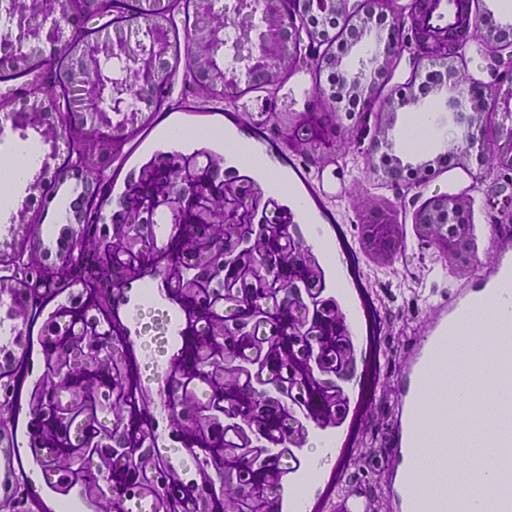

In [21]:
plot_annotated_image(tiles_dicts[1000])

<p style="font-family: consolas; font-size: 16px;">⚪ Take for example another tile with id <code>0870e4f9d580</code>. In the polygons.jsonl list, this tile has an index of <i>50</i>.</p>

In [22]:
tiles_dicts[50]["id"]

'0870e4f9d580'

In [23]:
tile_meta_df[tile_meta_df.id == "0870e4f9d580"]

,id,source_wsi,dataset,i,j
253,0870e4f9d580,2,2,24576,23040



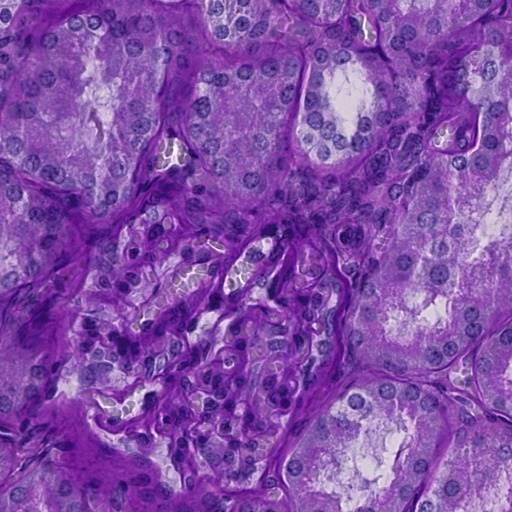

In [24]:
plot_annotated_image(tiles_dicts[50])

<p style="font-family: consolas; font-size: 16px;">⚪ Take for example another tile with id <code>0033bbc76b6b</code>. In the polygons.jsonl list, this tile has an index of <i>2</i>.</p>

In [25]:
tiles_dicts[2]["id"]

'0033bbc76b6b'

In [26]:
tile_meta_df[tile_meta_df.id == "0033bbc76b6b"]

,id,source_wsi,dataset,i,j
4,0033bbc76b6b,1,1,10240,43008



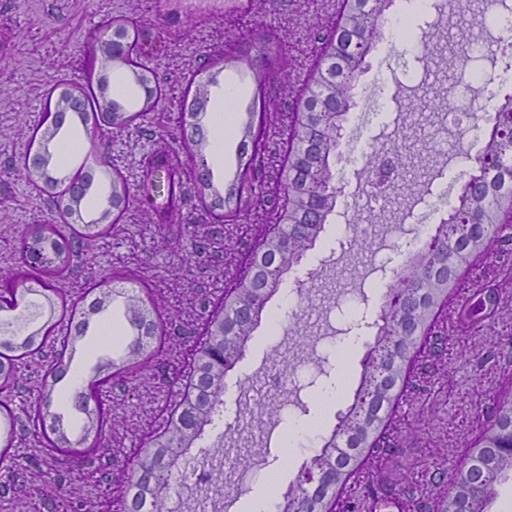

In [27]:
plot_annotated_image(tiles_dicts[2])

<p style="font-family: consolas; font-size: 16px;">⚪ Take for example another tile with id <code>4ca084aec87b</code>. In the polygons.jsonl list, this tile has an index of <i>500</i>.</p>

In [28]:
tiles_dicts[500]["id"]

'4ca084aec87b'

In [29]:
tile_meta_df[tile_meta_df.id == "4ca084aec87b"]

,id,source_wsi,dataset,i,j
2153,4ca084aec87b,2,1,17408,22016



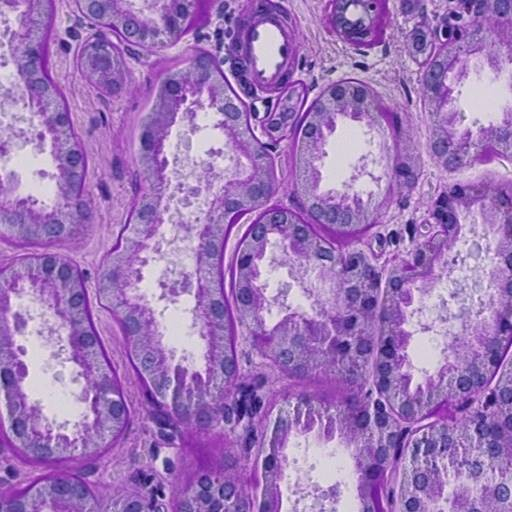

In [30]:
plot_annotated_image(tiles_dicts[500])

In [ ]:
# (⁠ ⁠ꈍ⁠ᴗ⁠ꈍ⁠) WORK STILL IN PROGRESS

# <div style="box-shadow: rgba(240, 46, 170, 0.4) -5px 5px inset, rgba(240, 46, 170, 0.3) -10px 10px inset, rgba(240, 46, 170, 0.2) -15px 15px inset, rgba(240, 46, 170, 0.1) -20px 20px inset, rgba(240, 46, 170, 0.05) -25px 25px inset; padding:20px; font-size:30px; font-family: consolas; display:fill; border-radius:15px; color: rgba(240, 46, 170, 0.7)"> <b> ༼⁠ ⁠つ⁠ ⁠◕⁠‿⁠◕⁠ ⁠༽⁠つ Thank You!</b></div>

<p style="font-family:verdana; color:rgb(34, 34, 34); font-family: consolas; font-size: 16px;"> 💌 Thank you for taking the time to read through my notebook. I hope you found it interesting and informative. If you have any feedback or suggestions for improvement, please don't hesitate to let me know in the comments. <br><br> 🚀 If you liked this notebook, please consider upvoting it so that others can discover it too. Your support means a lot to me, and it helps to motivate me to create more content in the future. <br><br> ❤️ Once again, thank you for your support, and I hope to see you again soon!</p>